Summary of IPython notebook examples
---------------------
This application is a notebook interface to the model defined in `basic.py`. It produces a visualization of the performance of a photovoltaic 
energy collection and storage system over the course of one year of operation on an hour-by-hour basis, based on a variety of parameters:

 - Geographic location
 - PV array size (in rated watts)
 - Battery bank size (in watt-hours)
 - Power usage (load) specification (constant, daytime, night time, or direct PV load)

Using location-based data, the time series model then simulates one-year of 
operation of the described system, on an hour-by-hour basis. 

Limitations and assumptions:
------------
- The model is entirely based in simple power balancing. Losses due DC-DC conversion, transmission loss or power inversion are modeled with an efficiency coefficient on the panel side (`data.losses`), and not currently modeled between the battery and the loads. For now, DC-DC losses between the battery and the load should be taken account by increasing the load power specifications.
- Related: a full battery charge/discharge curve isn't simulated in the state-of-charge integration. The SOC calculation does not take into account charge/discharge rate limitations or dynamics based on a specific battery chemistry.
- The state of charge computed is NOT a percent of a nominal amp-hour rating (the usual definition of SOC), but of the user-set watt-hour value. 
- In a real-world setting, your effective solar line-of-sight may be limited due to objects on the horizon (trees, other structures, etc.) The NREL data, to my best understanding, is based on an assumption of unobstructed line-of-sight, which may not be the case especially at the very beginning and very end of the day where solar illumination is transitioning. However, I have included options for hard cut-off times to be set to model a real-world situation (see examples below).

Technical details of many of these assumptions are provided in the PVWATTS manual:

https://developer.nrel.gov/docs/solar/pvwatts-v5/

Getting NREL data<a name="nrel_data"></a>
---------------------

The NREL data is automatically parsed for the model based on the location and solar panel array parameters that are inputted, by making use of the [PVWATTS API](https://developer.nrel.gov/docs/solar/pvwatts-v5/).
The model defaults to a demo API key that is presumably rate-limited. A free personal API key is available by signing up at: https://developer.nrel.gov/signup/

Each time the model is run, the NREL servers will be queried for data. I am working on a simple caching scheme that will be used for optimization algorithms, or other operations which would be expected to run the model many times.

NREL data also contains wind information that could potentially be used for wind turbine sizing for a hybrid solar-wind system in the future.

Examples
---------------
Now we'll execute some working examples

In [ ]:
# first, make the necessary imports
import warnings
warnings.filterwarnings("ignore")

from openmdao.api import Problem
from lib.basic import Basic
from lib.make_plot import make_plot
import pylab
%matplotlib inline

# now set up our model
top = Problem()
top.root = Basic()
top.setup(check=False)

# Set your NREL API key here:
top.root.data.nrel_api_key = "DEMO_KEY"

Model parameters
------------------

Below are an example of parameters that can be modified for a particular run.

You can run this block to quickly reset all default values.

In [3]:
# location (address, zip, etc.) query string 
# (uses Google geo-location services)
top.root.data.location = "Cleveland, Ohio"

# cut off times for PV power due to shading (default: no cut-off (0, 23))
top.root.data.start_time = 0
top.root.data.end_time = 23

"""
LOAD SPECIFICATION
"""
# constant background power load (Watt)
top['loads.P_constant'] = 0.0
# night time only power load (Watt)
top['loads.P_daytime'] = 0.0
# day time only power load (Watt)
top['loads.P_nighttime'] = 0.0
# direct PV power load (Watt)
top['loads.P_direct'] = 0.0
# min. temp for direct PV power load (deg. F)
top['loads.switch_temp'] = -1e99

"""
SYSTEM SPECIFICATION
"""

# Solar array types:
# 0 = Fixed - Open Rack (default)
# 1 = Fixed - Roof Mounted
# 2 = Tracking 1-Axis 
# 3 = Tracking 1-Axis Backtracking
# 4 = Tracking 2-Axis

top.root.data.array_type = 0
# Tilt of solar array (degrees, 0 = flat horizontal, 90 = vertical, default : 20)
top['data.array_tilt'] = 20
# General system losses (percentage of DC energy, default: 14)
top['data.losses'] = 14
# Rated power of solar array (Watt)
top['des_vars.array_power'] = 0 
# Battery power capacity (Watt-hr)
top['des_vars.power_capacity'] = 0 # Watt-hours

There are a lot of tunable parameters here, so let's run a concrete example.

Example: Tiny panel w/ LiPo battery and LED light
-------------------------------------------------
Consider setting up a [5.2 W panel](https://www.sparkfun.com/products/9241) with a [2000 mAh 3.7V LiPo battery](https://www.sparkfun.com/products/8483), controlled via a [small MPPT controller](https://www.sparkfun.com/products/12885). We'll plan to use this to power an LED that is measured to draw 0.1 W when powered by the full battery.

So the power capacity of the battery is: 2Ah * 3.7V = 7.4 Wh, and we can run our model with the following settings:


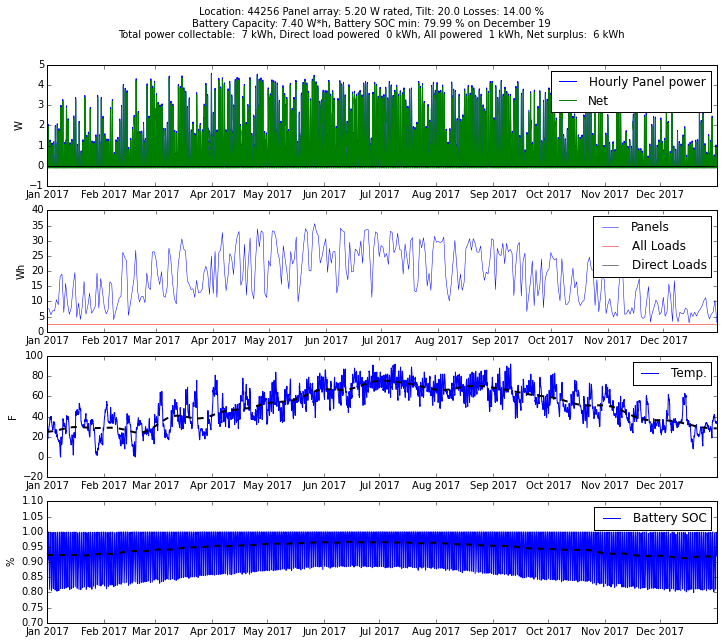

In [4]:
top.root.data.location = "44256"

top['loads.P_constant'] = 0.1
top['des_vars.array_power'] = 5.2 
top['des_vars.power_capacity'] = 2*3.7

# now actually run the model
# should take only a few seconds. most of the time is spent getting the NREL data.
top.run()

# post-process and display results
fig = make_plot(top)

Interpretations:

- Looking at summary information at the top: 
	- The model predicts that the system, run continuously, will never discharge the LiPo battery below 79.9%, reached during the winter (as expected). 
	- Over the simulated year, It is also noted that a total of 6kWh of energy can be collected by the panel in its location, with 5kWh net collectible (total collectible energy minus LED energy use). 
	- This 5kWh is wasted in a certain sense, but that is a normal trade-off with battery-backup PV systems.

- The first subplot (hourly power values) shows that we are unlikely to ever really get 5.2 W out of the panel. Over the course of the day, we get anywhere from 1 W to about 4 W. Also, the large amount of green (net) collectible energy shows that our load isn't using a large percentage of it most of the time during daylight hours.

- The second subplot (daily energy totals) shows that we can collect from 5 to 30 Wh energy every day from the panel (blue trace). The red trace shows the total load energy used each day, a constant 2.4 Wh every day for our model.

- The third subplot (ambient conditions) shows ambient temperature variation over the year, 0 to 100 F transition over the course of the year. This doesn't tell us much here, but future versions of this model will allow this to be taken into account for battery charge characteristics, temperature-dependent load specifications, etc. 

- The last subplot (battery SOC) shows that the battery SOC oscillates pretty regularly with the day-night cycles, with the night period being getting longer in the winter. Again, no major surprises here. 

Overall, not discharging the battery below about 80% is pretty good, and would preserve the life of the battery very well over time.

Example: Tiny panel w/ LiPo battery and LED light V.2
----------------------------------------------------
Let's rerun the last example, but this time let's only run the LED at night, but run an [Arduino 3.3v Pro Mini](https://www.sparkfun.com/products/11114) constantly. I estimate that, powered by the LiPo battery, the Arduino will consume about 0.05 A * 3.7 V = 0.185 W.

Let's also set the model to only count energy collected between 10am and 3pm (due to shadowing from trees around my area at dawn and dusk).

We would then run:

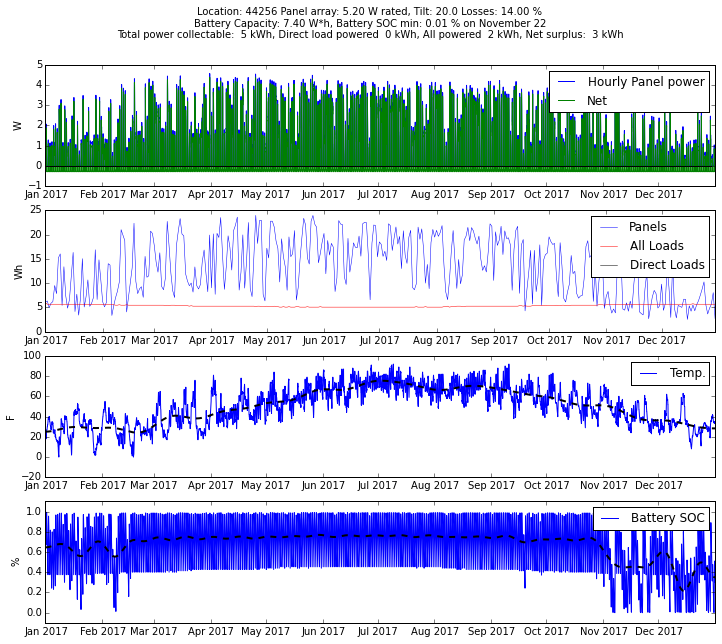

In [5]:
top.root.data.start_time = 10
top.root.data.end_time = 15

top['loads.P_constant'] = 0.05 * 3.7
top['loads.P_nighttime'] = 0.1

top.run()

fig = make_plot(top)

- The first subplot shows that the net hourly power generally dips further into the negative (during the night hours, naturally).

- The second subplot shows that in the winter, the net power collected over each day (blue trace value minus the red trace value) is sometimes negative. The battery subplot (bottom) shows that on these days, the battery tends to be deeply discharged, as expected.

- So overall, we see that while the panel can still technically collect 3 kWh more over the year than is consumed, the battery can no longer keep the system running continuously anymore due to collection and storage deficiencies during the winter months. Because of this, the battery reaches full discharge several times. 

- While it bounces back and recharges typically within a day in our model, in reality most batteries have a very hard time recovering from complete discharges:
	- To successfully design this as real-world hands-off system, we would need to re-run this model with higher panel wattages, greater battery capacities, or reducing load specifications until the depth of discharge is a more reasonable level. 
	
	- A battery low-voltage disconnect (LVD) module should also be used as a backup measure to protect the battery from excessively deep discharging. An LVD could also be used in a case where the system doesn't really need to run continuously without any interruption, to simplify system design. But I tend to think of LVD like a fuse: something that should only operate as a contingency, and not as a normal part of operation.

Example: Solar water pump & night spotlight
-------------------------------------------------------
This example is the design of a solar water pumping station with a small night light.
For this, a [30 W DC water pump](http://www.amazon.com/Diaphragm-Pressure-Automatic-Purifier-Pressurizer/dp/B015FL84GA) will be powered only when at least 30 W of solar power is collectable from the array (basically treated as a direct load), and only when the ambient temperature is greater than 32 Deg. F (0 C). A constant background draw of 0.5W will also be made for sensors and micro-electronics, and 4 W will be used to power a [small LED outdoor light](http://www.amazon.com/Mr-lamp-White-50watt-Equivalent-Spotlight/dp/B017K9E7BQ/ref=sr_1_26?s=hi&ie=UTF8&qid=1451772369&sr=1-26&keywords=4+watt+led+bulb) during night hours.

Let's see if we can run this with a [100 W panel](http://www.amazon.com/Renogy-Watts-Volts-Monocrystalline-Solar/dp/B009Z6CW7O) and [12V, 35 Ah car battery](http://www.amazon.com/85980-D5722-Sealed-Battery-UB12350/dp/B001VV0318/ref=sr_1_1?ie=UTF8&qid=1451952230&sr=8-1&keywords=35+ah+battery) (12 V * 35 Ah = 420 Wh):

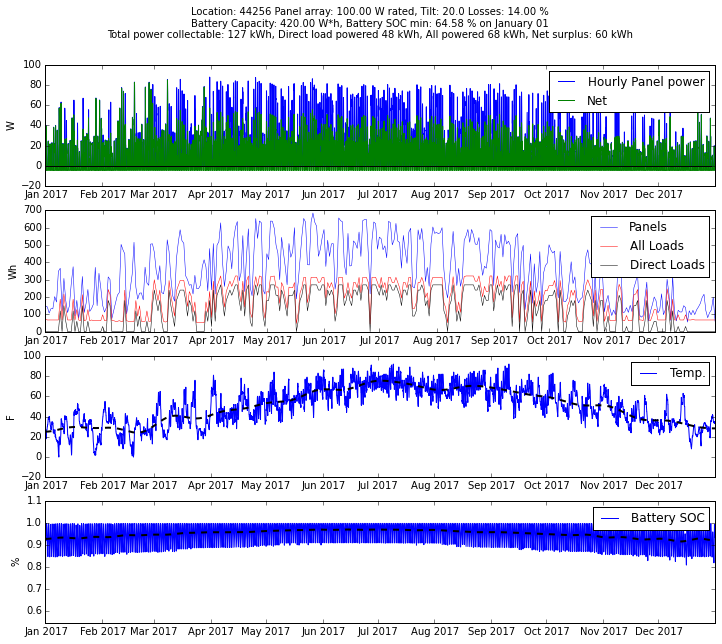

In [6]:
# reset cut-off times to defaults
top.root.data.start_time = 0
top.root.data.end_time = 23

top['loads.P_direct'] = 30.0
top['loads.switch_temp'] = 32.0
top['loads.P_constant'] = 0.5
top['loads.P_nighttime'] = 4.0

top['des_vars.array_power'] = 100 
top['des_vars.power_capacity'] = 420

top.run()

fig = make_plot(top)

Interpretation:

- The black line in the second subplot shows when the direct-load pump comes on, which is a bit sporadic. It looks as though in the summer months, we get about 250 Wh worth of energy directed into the pump at the needed condition (30W PV available, > 32 degrees). Since at 30 W, the pump can move 3 liters per minute, or about 47 gallons per hour, this gives us  about 391 pumped gallons per day during summer. 

- In the winter, the pump is practically hibernated, with very intermittent operation. 

- We also see that we get a total of about 45 kWh powered to the pump over the course of the year, which corresponds to about 70,000 gallons of pumped water.

- Battery SOC is not adversely affected by the daytime pump operation, and has an acceptable discharge depth of 80% occurring in the winter. 

- Experimenting with the model shows that SOC is much more sensitive to the constant background loads than the pump load level, since the system will not operate the pump unless the panel can support it directly. Thus, the pump operation largely bypasses the battery storage, but uses energy during the day at the expense of operating the light at night (via the battery). 
- Interestingly, for a fixed PV array and battery size, the directly load power level (the pump wattage) that maximizes total energy delivered to the pump over the year is not directly intuitive - setting it very low does not deliver as much cumulative energy, while setting it too high does not turn it on often enough to maximize delivered energy. For a 100W panel + 420 Wh battery, a 30W pump seems to have about the maximum annual energy you can put to use - around the 45 kWh collected in the example. 
 
 - Exploring this a bit: 
     
     

In [9]:
# experimenting with different pump power levels
for pump_power in [18, 30, 50]:
    top['loads.P_direct'] = pump_power
    top.run()
    print top['loads.P_consumption_direct'].sum(), top['batteries.SOC'].min()

40968.0 0.739569863222
47610.0 0.809650901434
45200.0 0.809650901434


     - with a 18W pump its 40 kWh over the year, with a 74% minimum battery SOC level
	  
	 - with a 30W pump (same run above) its 48 kWh with 80% minimum SOC
	  
	 - with a 50W pump you get 45 kWh , with 80% minimum SOC

Assuming that the total amount of water that you can pump over a year is directly correlated to the total energy delivered to it, It's a pretty interesting design space with non-trivial constraints (especially when you consider practical battery charge and discharge limitations).

Example: Whole-House residential grid-tie system
-------------------------------------------------
For this, a PV array will be sized to negate the electrical power usage of an average
home. Battery SOC will be neglected, and it will be assumed that it is a grid-tie system.

The average american home uses [about 911 kWh of energy per month](https://www.eia.gov/tools/faqs/faq.cfm?id=97&t=3). I'll bump this up to 1000 kWh to make it a nice round number.

1000 kWh per month corresponds to about a constant power draw of 1370 W.
Let's analyze the suitability of a 9.5 kilowatt residential PV system in my area: 

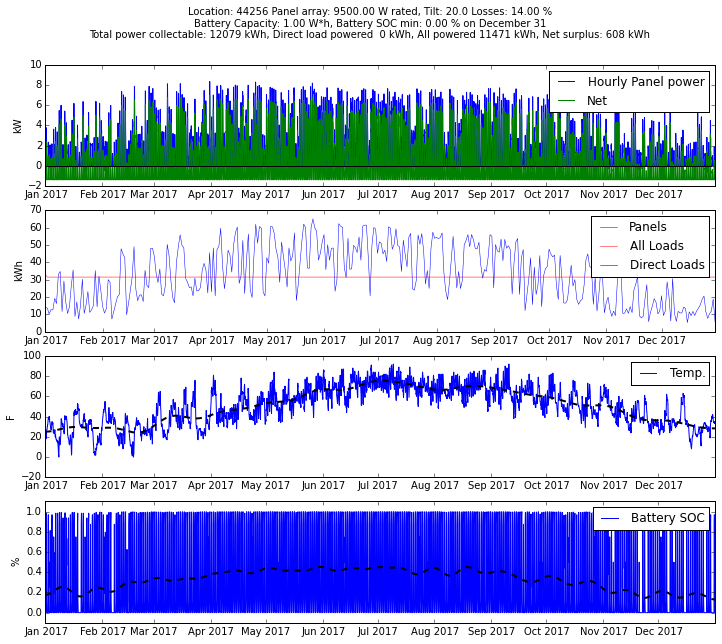

In [12]:
# resetting these back to defaults
top['loads.P_direct'] = 0.0
top['loads.P_nighttime'] = 0.0

top['loads.P_constant'] = 1370

top['des_vars.array_power'] = 9500
top['des_vars.power_capacity'] = 1

top.run()

fig = make_plot(top)

For this, the summary data at the top of the figure is probably the most informative: 

- A 9.5Kw allows this home to break even with their electrical usage, with a small estimated 608 kWh net surplus (collectible power - loads).
- Unlike the other examples, any net surplus wattage amount is actually
collected and used (in this case, transmitted to the power grid). If you oversize the array (say, with a 15kW system) you can see the amount of power that can be sold to the electric utility. 
- In the grid-tie setup, AC power from the grid effectively plays the role that the DC batteries played in the previous models. 

We also note in the daily summary (second subplot) that between November and March, the home would pull more energy from the grid than it delivers. For the rest of the year, it tends to deliver more to the grid than it receives (though this naturally has some oscillation).

Of course, the practical issue of off-setting the initial investment is another kind of analysis. As I noted above, for my purposes I'm mostly interested in low power off-grid autonomous applications, but I do think the rough conclusions interpreted here are meaningful. For this kind of system, there are a variety of good calculator applications on the internet that can be used to help study trade-offs.

Finally, you can use [the template notebook](template.ipynb) to run your own example cases without overwriting this example notebook.